In [1]:
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from astropy.io import fits
import tqdm
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/Users/dhortadarrington/Documents/Projects/mw-bar/data/table_centroids.fits'
tb = fits.open(path)
data = tb[1].data 

In [3]:
mask_disc = np.where(data['comp']=='disc')
mask_knot = np.where(data['comp']=='knot')
mask_bar = np.where(data['comp']=='bar')


In [4]:
lz = data['Lz']
lz_min = (data['Lz-'])
lz_max = (data['Lz+'])

angle = 90 - data['alpha']
angle_min = (data['alpha-'])
angle_max = (data['alpha+'])

In [5]:
import h5py
f = h5py.File("/Users/dhortadarrington/Documents/Projects/mw-bar/data/AllClassifications_APOGEE_all_feh8_SNRc.h5","r")
# f.keys() # this would list all the APOGEE IDs, including doubles for half-integer bins
median_knot_probability = []
median_bar_probability = []
median_disc_probability = []
std_knot_probability = []
std_bar_probability = []
std_disc_probability = []
all_knot_probability = []
all_bar_probability = []
all_disc_probability = []
RxyzL = []


for key in tqdm.tqdm_notebook(f.keys()):
    median_knot_probability.append(np.nanmedian(f[key][:,2]))
    median_bar_probability.append(np.nanmedian(f[key][:,1]))
    median_disc_probability.append(np.nanmedian(f[key][:,0]))
    std_knot_probability.append(np.nanstd(f[key][:,2]))
    std_bar_probability.append(np.nanstd(f[key][:,1]))
    std_disc_probability.append(np.nanstd(f[key][:,0]))
    all_knot_probability.append((f[key][:,2]))
    all_bar_probability.append((f[key][:,1]))
    all_disc_probability.append((f[key][:,0]))
    RxyzL.append(f[key][:,3][:7])
f.close() # don't forget to close the file!



  0%|          | 0/32489 [00:00<?, ?it/s]

In [6]:
print(np.shape(median_bar_probability))

(32489,)


In [7]:
mask_knot2 = (np.array(median_knot_probability)>0.8)&(np.array(std_knot_probability)<0.15)
mask_bar2 = (np.array(median_bar_probability)>0.8)&(np.array(std_bar_probability)<0.15)
mask_disc2 = (np.array(median_disc_probability)>0.8)&(np.array(std_disc_probability)<0.15)
RxyzL_ = np.array(RxyzL)
R = RxyzL_[:,0]
x = RxyzL_[:,1]
y = RxyzL_[:,2]
z = RxyzL_[:,3]
Lx = RxyzL_[:,4]
Ly = RxyzL_[:,5]
Lz = RxyzL_[:,6]*-1


In [8]:
import h5py
f = h5py.File("/Users/dhortadarrington/Documents/Projects/mw-bar/data/AllClassifications_APOGEE_all_feh8_SNRc.h5","r")
apo_ids = []
apo_ids2 = []
apo_ids3 = []
for key in tqdm.tqdm_notebook(f.keys()):
    new_key = key.replace("*", "")
    apo_ids.append(new_key)
    apo_ids3.append(key)
    if '*' in key:
        pass
    else:
        apo_ids2.append(key)
f.close() # don't forget to close the file!


  0%|          | 0/32489 [00:00<?, ?it/s]

# fit the data weighted by the probability

let our function be y = mx + b. The weighted linear regression is fitted by finding the derivative of a chi squared function for all possible parameter values (in this case m and x). This is referred to as a "loss function"

This loss function can also be weighted, such that $\chi^{2} = \Sigma_{i=1}^{n} \omega_{i}*\epsilon_{i}^{2}$, where $\epsilon_{i} = y_{i} - (x_{i}m + b)$


In [9]:
# for linear model with no intercept, the b in above equation drops out. The derivative of the chi2 w.r.t. m gives you the solution for m
# this yields m = (Sum_i=1^n w_i*(y_i - yhat)*(x_i - xhat))/(Sum_i=1^n w_i*(x_i - xhat)**2)
# where yhat = (Sum_i=1^n w_i*y_i)/(Sum_i=1^n w_i) and xhat = (Sum_i=1^n w_i*x_i)/(Sum_i=1^n w_i)

XS = R**2
YS = Lz
weights = np.array(median_bar_probability)

yhat = (np.sum(weights*YS))/(np.sum(weights))
xhat = (np.sum(weights*XS))/(np.sum(weights))

slope = (np.sum(weights*(YS - yhat)*(XS-xhat)))/(np.sum(weights*(XS-xhat)**2))
print(slope)


23.077210676118444


In [10]:
def linear(xs,m):
    return m*xs

In [11]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(linear,R**2,Lz) 
popt

array([39.64348562])

Text(0, 0.5, '$L_{z}$')

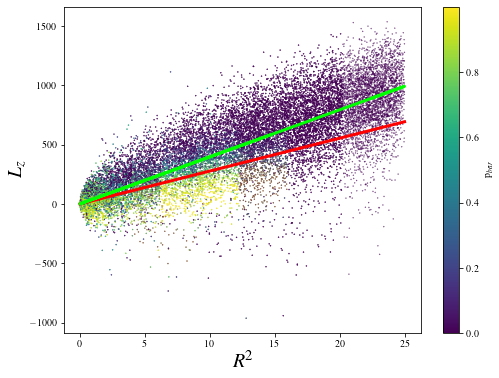

In [12]:
plt.figure(figsize=(8,6),facecolor='white')
plt.scatter(XS,YS,c=weights,s=0.1)
plt.plot(np.linspace(0,25,100),linear(np.linspace(0,30,100),slope),color='r',lw=3)
plt.plot(XS,linear(XS,popt),color='lime',lw=3)
plt.colorbar(label='p$_{bar}$')
plt.xlabel('$R^{2}$',fontsize=20)
plt.ylabel('$L_{z}$',fontsize=20)


This is the same as creating a loss function, and mininmising that loss function to find the best fitting params

In [13]:
def linear(xs,m):
    return m*xs

In [14]:
def loss(w):
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(linear,XS,YS)     
    ypred = linear(XS,w)
    # here we will use a weighted least squares
    return np.sum(weights*(YS-ypred)**2)
    

In [15]:
from scipy.optimize import fmin, minimize

res = minimize(loss, popt, method='nelder-mead')


In [16]:
print(res['x'])

[23.89152746]


Text(0, 0.5, '$L_{z}$')

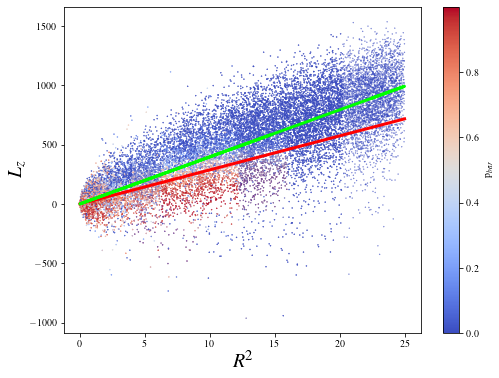

In [17]:
plt.figure(figsize=(8,6),facecolor='white')
plt.scatter(XS,YS,c=weights,s=0.1,cmap='coolwarm')
plt.plot(np.linspace(0,25,100),linear(np.linspace(0,30,100),res['x']),color='r',lw=3)
plt.plot(XS,linear(XS,popt),color='lime',lw=3)
plt.colorbar(label='p$_{bar}$')
plt.xlabel('$R^{2}$',fontsize=20)
plt.ylabel('$L_{z}$',fontsize=20)


# Now do the same bootstrapping to get the errors

In [57]:
XS = R**2
YS = Lz
weights = np.array(all_bar_probability)


In [58]:
def loss(w):
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(linear,XS,YS)     
    ypred = linear(XS,w)
    # here we will use a weighted least squares
    return np.sum(weights*(YS-ypred)**2)

In [59]:
res = []
for indx, i in tqdm.tqdm_notebook(enumerate(weights.T)):
    def loss2(w):
        popt, pcov = curve_fit(linear,XS,YS)     
        ypred = linear(XS,w)
        # here we will use a weighted least squares
        return np.sum(i*(YS-ypred)**2)

    res.append(minimize(loss2, popt, method='nelder-mead'))

    
    

0it [00:00, ?it/s]

In [60]:
slopes = []
for indx, i in enumerate(res):
    slopes.append(i['x'])
slopes = np.array(slopes).T[0]

In [61]:
print(np.mean(slopes))
print(np.std(slopes))

24.10113688648928
0.8923343264068501


In [80]:
XS = R**2
YS = Lz
weights2 = np.array(all_disc_probability)

In [81]:
res_disc = []
for indx, i in tqdm.tqdm_notebook(enumerate(weights2.T)):
    def loss2(w):
        popt, pcov = curve_fit(linear,XS,YS)     
        ypred = linear(XS,w)
        # here we will use a weighted least squares
        return np.sum(i*(YS-ypred)**2)

    res_disc.append(minimize(loss2, popt, method='nelder-mead'))

    
    

0it [00:00, ?it/s]

In [82]:
slopes_disc = []
for indx, i in enumerate(res_disc):
    slopes_disc.append(i['x'])
slopes_disc = np.array(slopes_disc).T[0]

In [83]:
print(np.nanmean(slopes_disc))

41.0322820893563


# Now repeat for the stars outside 2 kpc

In [66]:
XS = R[R>2]**2
YS = Lz[R>2]
weights = np.array(all_bar_probability)[R>2]


In [67]:
res2 = []
for indx, i in tqdm.tqdm_notebook(enumerate(weights.T)):
    def loss2(w):
        popt, pcov = curve_fit(linear,XS,YS)     
        ypred = linear(XS,w)
        # here we will use a weighted least squares
        return np.sum(i*(YS-ypred)**2)

    res2.append(minimize(loss2, popt, method='nelder-mead'))

    
    

0it [00:00, ?it/s]

In [68]:
slopes2 = []
for indx, i in enumerate(res2):
    slopes2.append(i['x'])
slopes2 = np.array(slopes2).T[0]
print(np.mean(slopes2))
print(np.std(slopes2))

24.054261531645864
0.9222554842248357


(0.0, 1500.0)

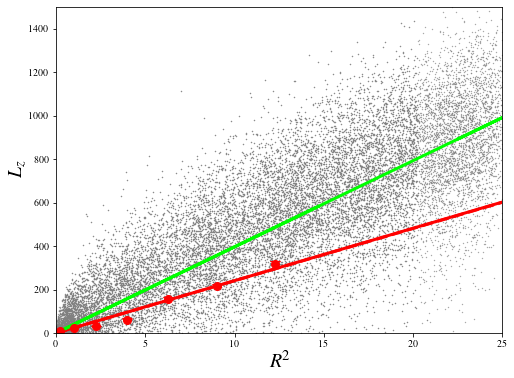

In [69]:
plt.figure(figsize=(8,6),facecolor='white')
plt.scatter(R**2,Lz,s=0.1,c='gray')
# c=np.nanmedian(weights,axis=1),
plt.plot(np.linspace(0,25,100),linear(np.linspace(0,25,100),np.mean(slopes)),color='r',lw=3)
plt.plot(np.linspace(0,25,100),linear(np.linspace(0,25,100),np.mean(slopes2)),color='r',lw=3,ls='dashed')
plt.errorbar((data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1,yerr = [lz_min[mask_bar],lz_max[mask_bar]],\
                fmt='o',markersize=8, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
# plt.fill_between(np.linspace(0,25,100),linear(np.linspace(0,30,100),np.mean(slopes)-np.std(slopes)),\
#                  linear(np.linspace(0,30,100),np.mean(slopes)+np.std(slopes)),color='r',alpha=0.3)
plt.plot(R**2,linear(R**2,popt),color='lime',lw=3)
# plt.colorbar(label='p$_{bar}$')
plt.xlabel('$R^{2}$',fontsize=20)
plt.ylabel('$L_{z}$',fontsize=20)
plt.xlim(0,25)
plt.ylim(0,1500)

# Now fit the disc

In [31]:
XS = R
YS = Lz
weights = np.array(all_disc_probability)

In [32]:
print((weights))

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [0.15290293 0.48933055 0.3667328  ... 0.28136293 0.33119226 0.37920192]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [33]:
res = []
for indx, i in tqdm.tqdm_notebook(enumerate(weights.T)):
    def loss2(w):
        popt, pcov = curve_fit(linear,XS,YS)     
        ypred = linear(XS,w)
        # here we will use a weighted least squares
        return np.sum(i*(YS-ypred)**2)

    res.append(minimize(loss2, popt, method='nelder-mead'))

0it [00:00, ?it/s]

In [34]:
slopes = []
for indx, i in enumerate(res):
    slopes.append(i['x'])
slopes = np.array(slopes).T[0]

print(np.mean(slopes))
print(np.std(slopes))

167.39136057977552
0.45794069608744614


(0.0, 1500.0)

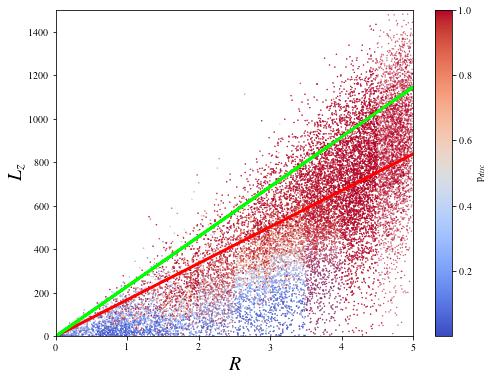

In [35]:
plt.figure(figsize=(8,6),facecolor='white')
plt.scatter(R,Lz,c=np.median(np.array(all_disc_probability),axis=1),s=0.1,cmap='coolwarm')
# c=np.nanmedian(weights,axis=1),
plt.plot(np.linspace(0,5,100),linear(np.linspace(0,5,100),np.mean(slopes)),color='r',lw=3)
# plt.errorbar((data['binmin'][mask_disc]+0.25),lz[mask_disc]*-1,yerr = [lz_min[mask_disc],lz_max[mask_disc]],\
#                 fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
# plt.fill_between(np.linspace(0,25,100),linear(np.linspace(0,30,100),np.mean(slopes)-np.std(slopes)),\
#                  linear(np.linspace(0,30,100),np.mean(slopes)+np.std(slopes)),color='r',alpha=0.3)
plt.plot(R,linear(R,229),color='lime',lw=3)
plt.colorbar(label='p$_{disc}$')
plt.xlabel('$R$',fontsize=20)
plt.ylabel('$L_{z}$',fontsize=20)
plt.xlim(0,5)
plt.ylim(0,1500)

In [49]:
def linear(xs,m):
    return m*xs

In [50]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(linear,R[Lz>0]**2,Lz[Lz>0]) 
popt

array([40.67475558])

In [51]:
def chi2(y_pred, y_true,weights):
    return jnp.sum(jnp.dot(weights,(y_true - y_pred)**2))

In [39]:
gradM = jit(grad(chi2,argnums=0))


NameError: name 'jit' is not defined

In [40]:
XS = R[Lz>0]**2
YS = Lz[Lz>0]
weights = jnp.array(median_bar_probability)[Lz>0]
m = gradM(YS,linear(XS,popt[0]),weights)


NameError: name 'jnp' is not defined

In [41]:
plt.scatter(m,np.linspace(0,1,len(m)),s=0.1)
print(jnp.mean(m[m>0]))


NameError: name 'm' is not defined

In [156]:
def exp(xs, k,n):
    return n*(1-np.exp(-k*xs))

# Make the angle and L$_{z}$ vs $R$ plot for the paper

In [159]:
radios = np.linspace(0,100,101)


In [160]:
# fit the whole thing without any weights
from scipy.optimize import curve_fit
popt, pcov = curve_fit(linear,R**2,Lz) 
popt

array([39.64348562])

In [161]:
# fit the whole thing without any weights
from scipy.optimize import curve_fit
popt_exp, pcov_exp = curve_fit(exp,R**2,Lz) 
popt_exp

array([1.11512298e-02, 3.91490213e+03])

In [74]:
# get also the scatter of the stars with high bar and disc probability
radios2 = np.linspace(0,25,20)
scatter_bar = np.zeros((len(radios2[:-1])))
for indx, i in enumerate(radios2[:-1]):
    mascara = (R**2>i)&(R**2<radios2[indx+1])&(np.array(median_bar_probability)>0.9)
    scatter_bar[indx] = np.nanstd(Lz[mascara])


In [75]:
# get also the scatter of the stars with high bar and disc probability
radios2 = np.linspace(0,25,20)
scatter_disc = np.zeros((len(radios2[:-1])))
for indx, i in enumerate(radios2[:-1]):
    mascara = (R**2>i)&(R**2<radios2[indx+1])&(np.array(median_disc_probability)>0.9)
    scatter_disc[indx] = np.nanstd(Lz[mascara])


In [76]:
np.nanstd(slopes_disc)
print(np.mean(slopes))

24.10113688648928


In [86]:
scatter_disc

array([ 94.42912872, 129.97258323, 143.71033296, 157.72682308,
       165.14761899, 132.99982595, 141.11781589, 143.13825051,
       154.07220022, 218.81288085, 226.22022316, 224.94655048,
       261.52850802, 253.49490165, 258.91030489, 256.4859556 ,
       245.7211905 , 260.57894763, 227.24511594])

In [77]:
# add Gonzalez et al 2011 values for rotated bar
angles = [30,35,40,45,46]
radiuses = [1.7,1.4,1.1,0.8,0.5]

(0.0, 90.0)

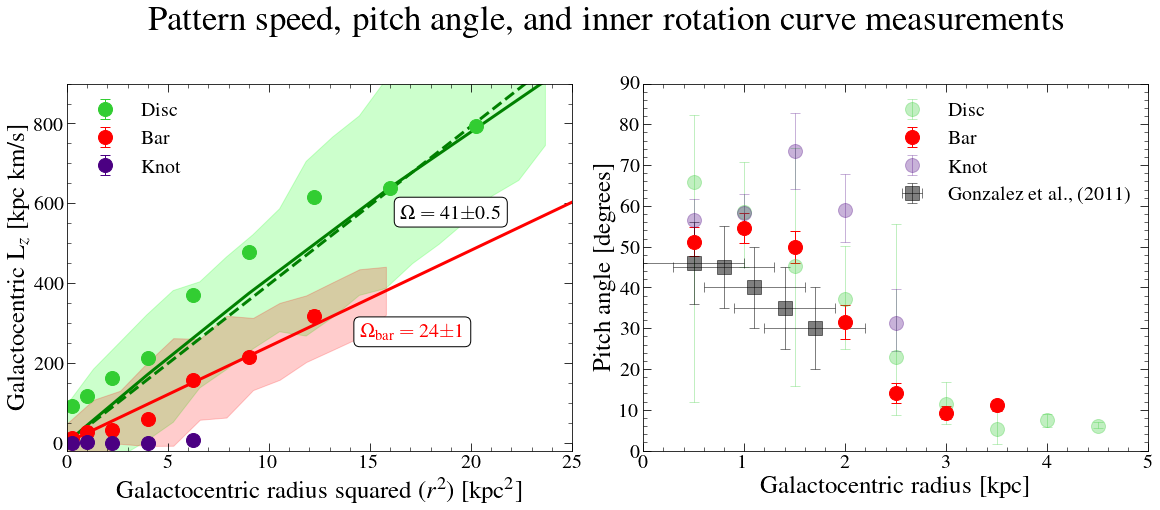

In [163]:
plt.figure(figsize=(16,6),facecolor='white',constrained_layout=True)

plt.figtext(0.125, 1.1,'Pattern speed, pitch angle, and inner rotation curve measurements',fontsize=35)
plt.subplot(1,2,1)
plt.plot(radios**2,linear(radios**2,popt),color='g',lw=3,ls='--')
plt.plot(radios**2,exp(radios**2,popt_exp[0],popt_exp[1]),color='g',lw=3)

plt.fill_between(radios2[:-1],linear(radios2[:-1],np.nanmean(slopes_disc))-scatter_disc,linear(radios2[:-1],np.nanmean(slopes_disc))+scatter_disc,\
                alpha=0.2,color='lime')
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(16.5,600, r'$\Omega =$ '+str("%.0f" % np.nanmean(slopes_disc))+'$\pm0.5$', fontsize=20,
        verticalalignment='top', bbox=props)
plt.errorbar((data['binmin'][mask_disc]+0.5)**2,lz[mask_disc]*-1,yerr = [lz_min[mask_disc],lz_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
plt.fill_between(radios2[:-1],linear(radios2[:-1],np.mean(slopes))-scatter_bar,linear(radios2[:-1],np.mean(slopes))+scatter_bar,\
                alpha=0.2,color='r')
plt.plot(radios**2,linear(radios**2,np.mean(slopes)),color='r',lw=3)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(14.5,300, r'$\Omega_{\mathrm{bar}} = $ '+str("%.0f" % np.mean(slopes))+'$\pm1$', fontsize=20,
        verticalalignment='top', bbox=props, color='r')
plt.errorbar((data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1,yerr = [lz_min[mask_bar],lz_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
plt.errorbar((data['binmin'][mask_knot]+0.5)**2,lz[mask_knot]*-1,yerr = [lz_min[mask_knot],lz_max[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot')
plt.xlabel(r'Galactocentric radius squared ($r^{2}$) [kpc$^{2}$]',fontsize=25)
plt.ylabel(r'Galactocentric L$_{z}$ [kpc km/s]',fontsize=25)
plt.legend(loc='upper left',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,25)
plt.ylim(-20,900)


plt.subplot(1,2,2)
plt.errorbar(data['binmin'][mask_disc]+0.5,angle[mask_disc],yerr = [-angle_min[mask_disc],angle_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc',alpha=0.3)
plt.errorbar(data['binmin'][mask_bar]+0.5,angle[mask_bar],yerr = [-angle_min[mask_bar],angle_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
plt.errorbar(data['binmin'][mask_knot]+0.5,angle[mask_knot],yerr = [-angle_min[mask_knot],angle_max[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot',alpha=0.3)
plt.errorbar(radiuses,angles,yerr = 10,xerr=0.5,\
                fmt='s',markersize=14, color='k',ecolor='k', elinewidth=1, capsize=5,label='Gonzalez et al., (2011)',alpha=0.5)
# plt.errorbar(radiuses,angles,c='k',s=200,marker='s',label='Gonzalez et al., (2011)',alpha=0.5)
plt.xlabel(r'Galactocentric radius [kpc]',fontsize=25)
plt.ylabel(r'Pitch angle [degrees]',fontsize=25)
plt.legend(loc='upper right',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,5)
plt.ylim(0,90)


In [129]:
rads_freq = np.linspace(5.,30,101)
freqs_eilers = np.zeros((len(rads_freq)))

for indx, i in enumerate(rads_freq):
    freqs_eilers[indx] = (229.0-(1.7*(i-8.275)))/i

vcirc_eilers = np.zeros((len(rads_freq)))
for indx, i in enumerate(rads_freq):
    vcirc_eilers[indx] = (229.0-(1.7*(i-8.275)))

In [127]:
rads_freq

array([ 5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,
        7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,
        9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 ,
       11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75,
       14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  ,
       16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75, 18.  , 18.25,
       18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  , 20.25, 20.5 ,
       20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25, 22.5 , 22.75,
       23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 , 24.75, 25.  ,
       25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75, 27.  , 27.25,
       27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  , 29.25, 29.5 ,
       29.75, 30.  ])

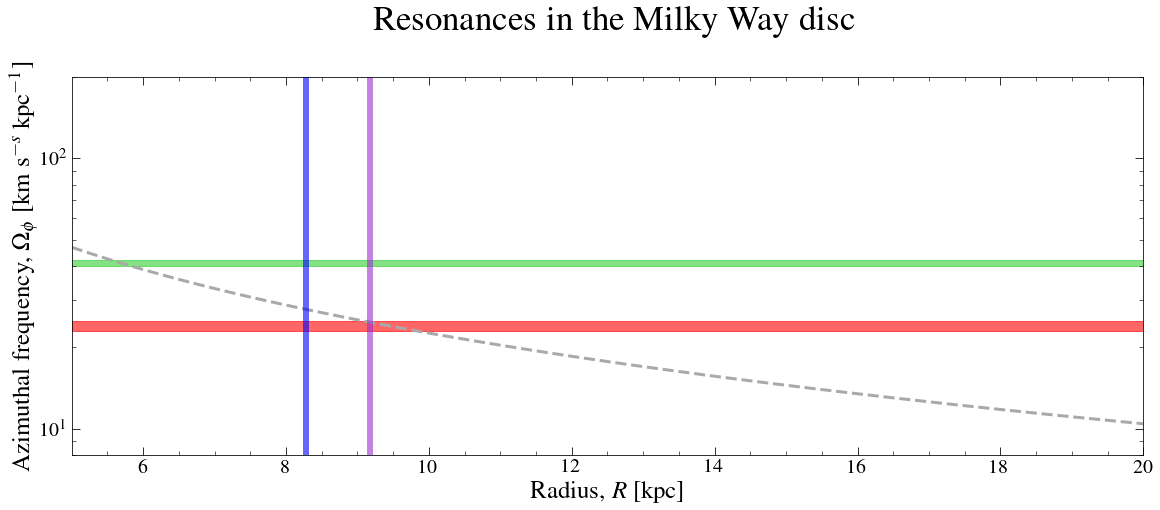

In [128]:
plt.figure(figsize=(16,6),facecolor='white',constrained_layout=True)

plt.figtext(0.32, 1.1,'Resonances in the Milky Way disc',fontsize=35)
plt.plot(rads_freq,freqs_eilers,color='darkgray',lw=3,ls='--')
plt.fill_between(rads_freq,23,25,alpha=0.6,color='r')
plt.fill_between(rads_freq,40,42,alpha=0.6,color='limegreen')
plt.vlines(8.275,0,200,color='b',alpha=0.6,lw=6)
plt.vlines(9.17,0,200,color='darkorchid',alpha=0.6,lw=6)
plt.xlim(5.,20)
plt.ylim(8,200)
plt.ylabel(r'Azimuthal frequency, $\Omega_{\phi}$ [km s$^{-s}$ kpc$^{-1}$]',fontsize=25)
plt.xlabel(r'Radius, $R$ [kpc]',fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
plt.yscale('log')



In [ ]:
plt.errorbar((data['binmin'][mask_disc]+0.5)**2,lz[mask_disc]*-1,yerr = [lz_min[mask_disc],lz_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')


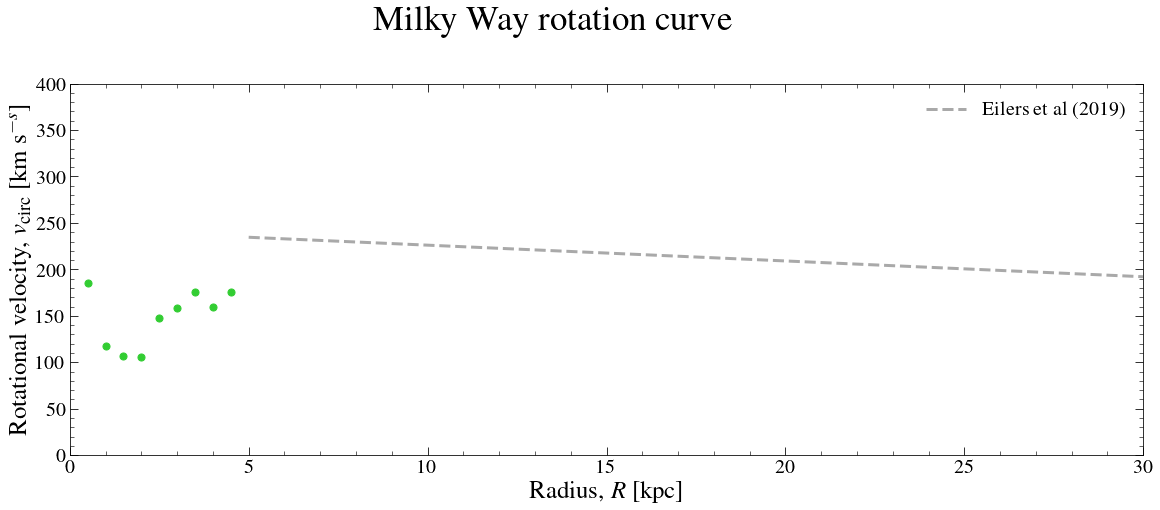

In [143]:
plt.figure(figsize=(16,6),facecolor='white',constrained_layout=True)

plt.figtext(0.32, 1.1,'Milky Way rotation curve',fontsize=35)
plt.plot(rads_freq,vcirc_eilers,color='darkgray',lw=3,ls='--', label='Eilers et al (2019)')
# plt.errorbar((data['binmin'][mask_disc]+0.5),(lz[mask_disc]*-1)/(data['binmin'][mask_disc]+0.5),\
#      yerr = [lz_min[mask_disc]/(data['binmin'][mask_disc]+0.5),lz_max[mask_disc]/(data['binmin'][mask_disc]+0.5)],\
#                 fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
plt.scatter(data['binmin'][mask_disc]+0.5,(lz[mask_disc]*-1)/(data['binmin'][mask_disc]+0.5),s=50,c='limegreen')

# plt.fill_between(rads_freq,23,25,alpha=0.6,color='r')
# plt.fill_between(rads_freq,40,42,alpha=0.6,color='limegreen')
# plt.vlines(8.275,0,200,color='b',alpha=0.6,lw=6)
# plt.vlines(9.17,0,200,color='darkorchid',alpha=0.6,lw=6)
plt.legend(loc='upper right',frameon=False,fontsize=20)
plt.xlim(0.,30)
plt.ylim(0,400)
plt.ylabel(r'Rotational velocity, $v_{\mathrm{circ}}$ [km s$^{-s}$]',fontsize=25)
plt.xlabel(r'Radius, $R$ [kpc]',fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()


(0.0, 200.0)

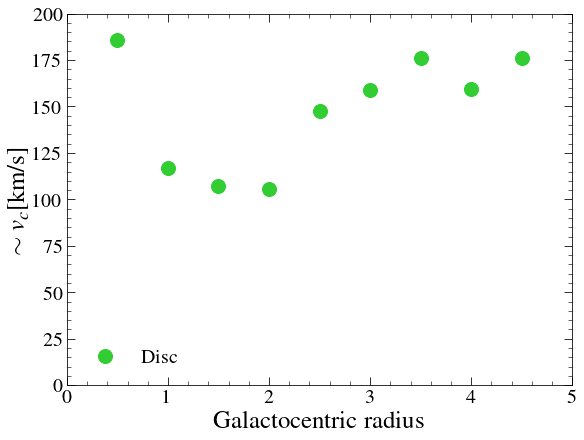

In [144]:
plt.figure(figsize=(8,6),facecolor='white',constrained_layout=True)


plt.errorbar((data['binmin'][mask_disc]+0.5),(lz[mask_disc]*-1)/(data['binmin'][mask_disc]+0.5),\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
plt.xlabel(r'Galactocentric radius',fontsize=25)
plt.ylabel(r'$\sim v_{c}$[km/s]',fontsize=25)
plt.legend(loc='lower left',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,5)
plt.ylim(0,200)

In [ ]:
16.5+65.8

In [ ]:
plt.scatter(R[[Lz>0]]**2,Lz[Lz>0],s=0.1)
plt.plot(np.linspace(0,25,100),linear(np.linspace(0,25,100),popt_bar[0],popt_bar[1]))
plt.colorbar()

In [ ]:
plt.hist(np.array(median_bar_probability)[Lz>0])

# Fit the centroids

In [88]:
def linear(xs,m,b):
    return xs*m+b

In [89]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(linear,(data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1) 
popt2, pcov2 = curve_fit(linear,(data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1+lz_max[mask_bar]) 
popt3, pcov3 = curve_fit(linear,(data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1+lz_min[mask_bar]) 
print(popt,popt2,popt3)
print(popt2[0]-popt[0])
print(popt[0]-popt3[0])

[ 26.12729144 -13.82217342] [ 27.08848521 -11.32814346] [ 25.08358146 -15.94648129]
0.9611937740485175
1.0437099786224024


In [90]:
# print(27.08848521-26.12729144)
# print(26.12729144-25.08358146)

In [91]:
popt_disc, pcov_disc = curve_fit(linear,(data['binmin'][mask_disc]+0.5),lz[mask_disc]*-1) 
popt2_disc, pcov2_disc = curve_fit(linear,(data['binmin'][mask_disc]+0.5),lz[mask_disc]*-1+lz_max[mask_disc]) 
popt3_disc, pcov3_disc = curve_fit(linear,(data['binmin'][mask_disc]+0.5),lz[mask_disc]*-1+lz_min[mask_disc]) 


In [92]:
# also get the derivative (i.e., the pattern speed)
popt_disc_pattern, pcov_disc_pattern = curve_fit(linear,(data['binmin'][mask_disc]+0.5)**2,lz[mask_disc]*-1) 
print(popt_disc_pattern)

[36.14722058 99.99005942]


In [93]:
print(popt_disc,popt2_disc,popt3_disc)
print(popt2_disc[0]-popt_disc[0])
print(popt_disc[0]-popt3_disc[0])

[184.6966662  -75.58611005] [183.4766613  -65.28054985] [185.77333933 -85.34445367]
-1.220004896715352
-1.0766731291618044


In [94]:
def vrot_disc(xs,vcirc, pattern):
    return vcirc+xs*pattern

In [95]:
xs_disc = np.linspace(0,5,101)
vrot = vrot_disc(xs_disc,popt_disc[0],popt_disc_pattern[0])
vrot_down = xs_disc*popt3_disc[0]
vrot_up = xs_disc*popt2_disc[0]
print(vrot)

xs_disc2 = np.linspace(5,25,200)

def eilers(xs,err=0.,err2=0.):
    return 229.0+err - (1.7+err2)*xs

vrot_eilers = eilers(xs_disc2)
vrot_eilers_up = eilers(xs_disc2,err=0.2,err2=0.1)
vrot_eilers_down = eilers(xs_disc2,err=-0.2,err2=-0.1)


[184.6966662  186.50402723 188.31138826 190.11874929 191.92611032
 193.73347135 195.54083238 197.3481934  199.15555443 200.96291546
 202.77027649 204.57763752 206.38499855 208.19235958 209.99972061
 211.80708164 213.61444267 215.4218037  217.22916473 219.03652575
 220.84388678 222.65124781 224.45860884 226.26596987 228.0733309
 229.88069193 231.68805296 233.49541399 235.30277502 237.11013605
 238.91749708 240.72485811 242.53221913 244.33958016 246.14694119
 247.95430222 249.76166325 251.56902428 253.37638531 255.18374634
 256.99110737 258.7984684  260.60582943 262.41319046 264.22055149
 266.02791251 267.83527354 269.64263457 271.4499956  273.25735663
 275.06471766 276.87207869 278.67943972 280.48680075 282.29416178
 284.10152281 285.90888384 287.71624486 289.52360589 291.33096692
 293.13832795 294.94568898 296.75305001 298.56041104 300.36777207
 302.1751331  303.98249413 305.78985516 307.59721619 309.40457722
 311.21193824 313.01929927 314.8266603  316.63402133 318.44138236
 320.248743

In [96]:
xs = np.linspace(0,13)
ys = linear(xs,popt[0],popt[1])
ys_disc = linear(xs_disc,popt_disc[0],popt_disc[1])


In [97]:
xst = np.linspace(0,13)
yst = linear(xs,40,0)


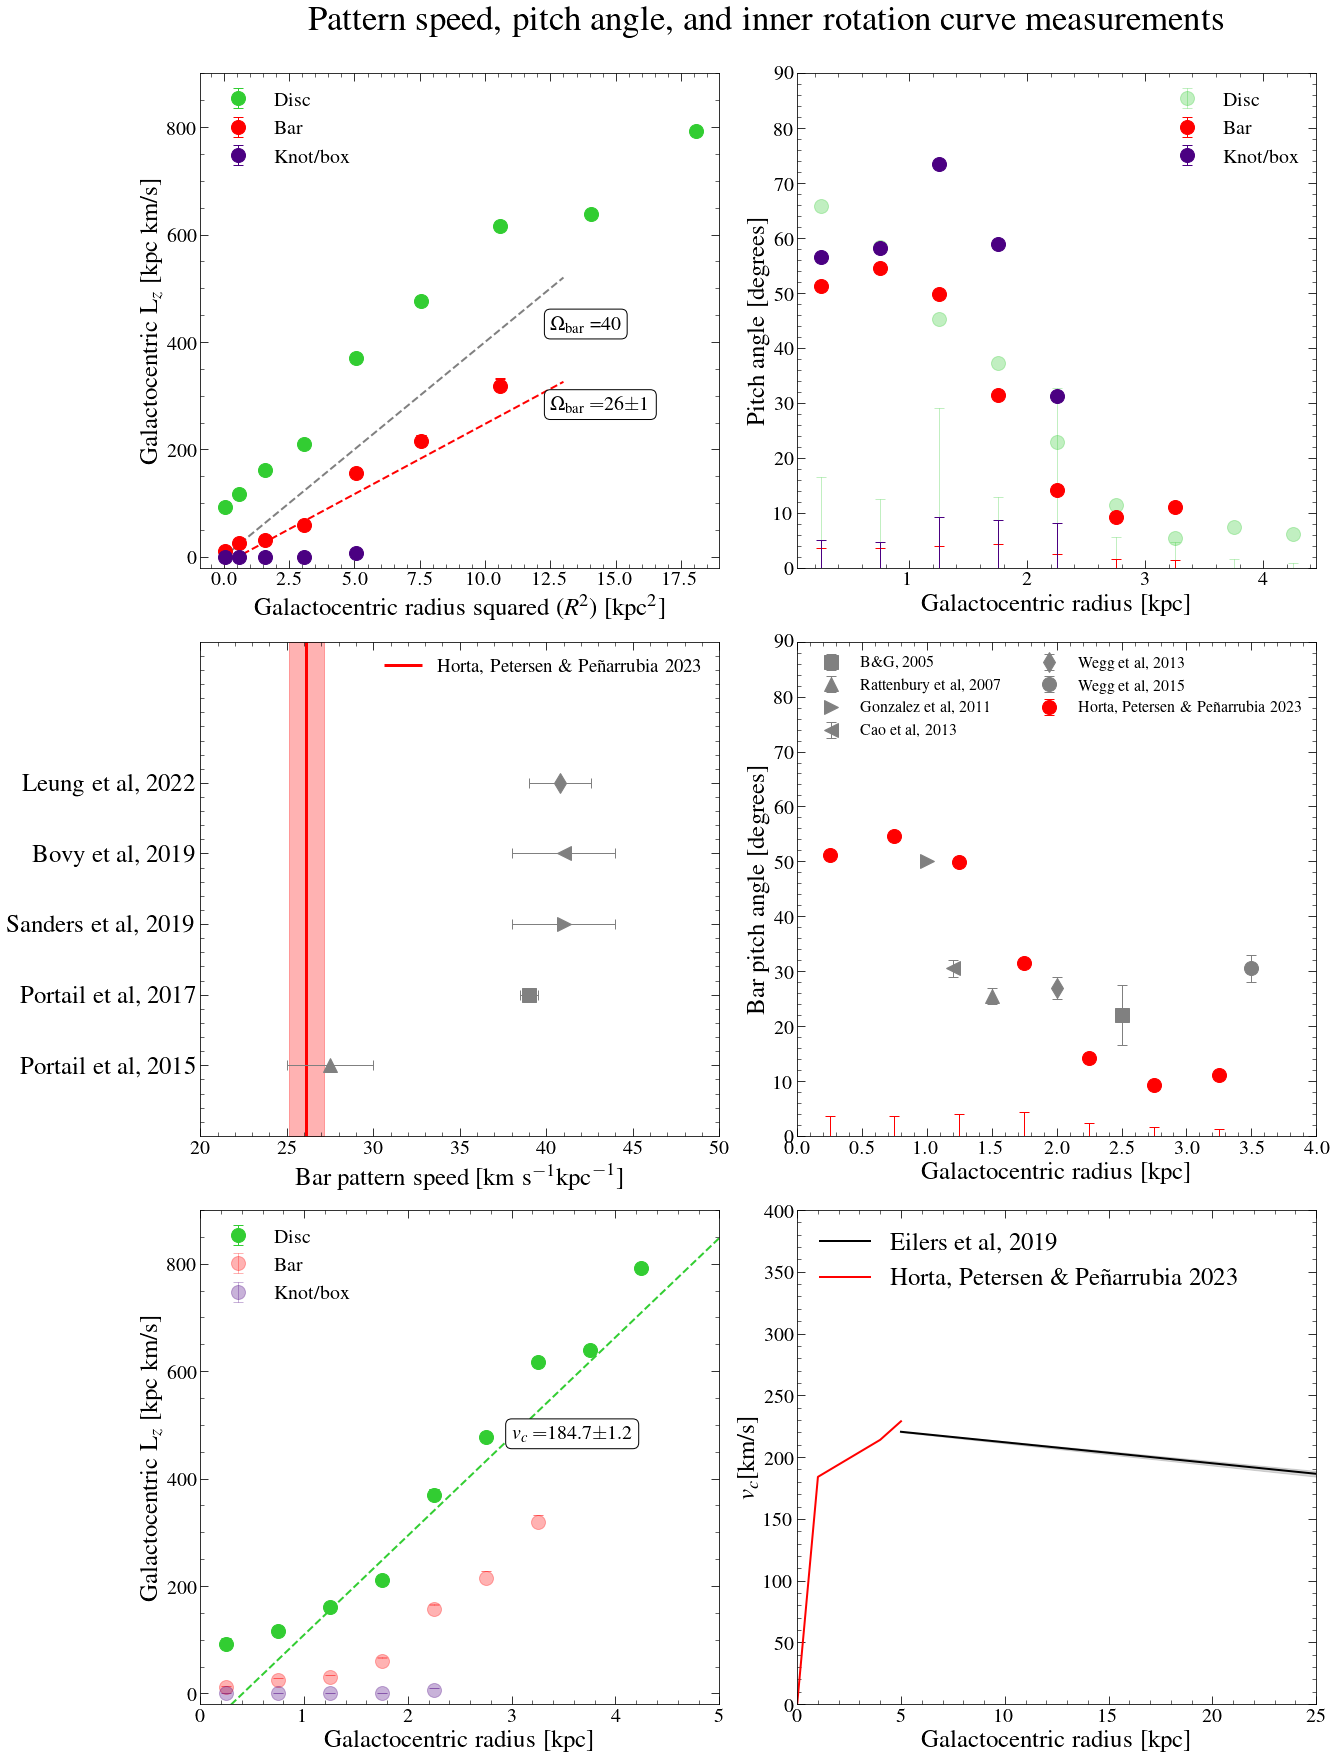

In [98]:
plt.figure(figsize=(20,30),facecolor='white',constrained_layout=True)

plt.figtext(0.2, 0.9,'Pattern speed, pitch angle, and inner rotation curve measurements',fontsize=35)
plt.subplot(3,2,1)

plt.plot(xst,yst,color='gray',ls='dashed',lw=2)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(12.5,450, r'$\Omega_{\mathrm{bar}}$ =40', fontsize=20,
        verticalalignment='top', bbox=props)
plt.errorbar((data['binmin'][mask_disc]+0.25)**2,lz[mask_disc]*-1,yerr = [lz_min[mask_disc],lz_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
plt.plot(xs,ys,color='r',ls='dashed',lw=2)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(12.5,300, r'$\Omega_{\mathrm{bar}} =$'+str("%.0f" % popt[0])+'$\pm1$', fontsize=20,
        verticalalignment='top', bbox=props)
plt.errorbar((data['binmin'][mask_bar]+0.25)**2,lz[mask_bar]*-1,yerr = [lz_min[mask_bar],lz_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
plt.errorbar((data['binmin'][mask_knot]+0.25)**2,lz[mask_knot]*-1,yerr = [lz_min[mask_knot],lz_max[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot/box')
plt.xlabel(r'Galactocentric radius squared ($R^{2}$) [kpc$^{2}$]',fontsize=25)
plt.ylabel(r'Galactocentric L$_{z}$ [kpc km/s]',fontsize=25)
plt.legend(loc='upper left',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
# plt.xlim(0,10)
plt.ylim(-20,900)


plt.subplot(3,2,2)
plt.errorbar(data['binmin'][mask_disc]+0.25,angle[mask_disc],yerr = [angle[mask_disc]-angle_min[mask_disc],angle_max[mask_disc]-angle[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc',alpha=0.3)
plt.errorbar(data['binmin'][mask_bar]+0.25,angle[mask_bar],yerr = [angle[mask_bar]-angle_min[mask_bar],angle_max[mask_bar]-angle[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
plt.errorbar(data['binmin'][mask_knot]+0.25,angle[mask_knot],yerr = [angle[mask_knot]-angle_min[mask_knot],angle_max[mask_knot]-angle[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot/box')
plt.xlabel(r'Galactocentric radius [kpc]',fontsize=25)
plt.ylabel(r'Pitch angle [degrees]',fontsize=25)
plt.legend(loc='upper right',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
# plt.xlim(0,10)
plt.ylim(0,90)


plt.subplot(3,2,3)
plt.vlines(26.13,0,7,lw=3,color='r',label='Horta, Petersen $\&$ Pe\~{n}arrubia 2023')
plt.fill_betweenx(np.linspace(0,7,8),25.13,27.13,color='r',alpha=0.3)
plt.errorbar(27.5,1, xerr =2.5,fmt='^',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5)
plt.errorbar(39,2, xerr =0.5,fmt='s',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5)
plt.errorbar(41,3, xerr =3,fmt='>',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5)
plt.errorbar(41,4, xerr =3,fmt='<',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5)
plt.errorbar(40.8,5, xerr =1.8,fmt='d',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5)
# plt.errorbar(29.7,6, xerr =1,fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Horta, Petersen, Pe\~{n}arrubia 2023')
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
positions = (1,2,3,4,5)
labels = ('Portail et al, 2015','Portail et al, 2017','Sanders et al, 2019','Bovy et al, 2019','Leung et al, 2022')
plt.legend(loc='upper right',fontsize=19,frameon=False,ncol=2)
plt.yticks(positions,labels,fontsize=25)
plt.xlabel(r'Bar pattern speed [km $\mathrm{s}^{-1} \mathrm{kpc}^{-1}$]',fontsize=25)
plt.ylabel('',fontsize=25)
# plt.yscale('log')
plt.ylim(0,7)
plt.xlim(20,50)


plt.subplot(3,2,4)
plt.errorbar(2.5,22, yerr =5.5,fmt='s',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='B$\&$G, 2005')
plt.errorbar(1.5,25.5, yerr =1.5,fmt='^',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='Rattenbury et al, 2007')
plt.errorbar(1,50,fmt='>',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='Gonzalez et al, 2011')
plt.errorbar(1.2,30.5, yerr =1.5,fmt='<',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='Cao et al, 2013')
plt.errorbar(2,27, yerr =2,fmt='d',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='Wegg et al, 2013')
plt.errorbar(3.5,30.5, yerr =2.5,fmt='o',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='Wegg et al, 2015')
plt.errorbar(data['binmin'][mask_bar]+0.25,angle[mask_bar],yerr = [angle[mask_bar]-angle_min[mask_bar],angle_max[mask_bar]-angle[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Horta, Petersen $\&$ Pe\~{n}arrubia 2023')

plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(loc='upper right',fontsize=16,frameon=False,ncol=2)
plt.xlabel(r'Galactocentric radius [kpc]',fontsize=25)
plt.ylabel(r'Bar pitch angle [degrees]',fontsize=25)
# plt.yscale('log')
plt.xlim(0,4)
plt.ylim(0,90)


plt.subplot(3,2,5)
plt.plot(xs_disc,ys_disc,color='limegreen',lw=2,ls='--')
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(3,500, r'$v_{c} =$'+str("%.1f" % popt_disc[0])+'$\pm$1.2', fontsize=20,
        verticalalignment='top', bbox=props)
plt.errorbar((data['binmin'][mask_disc]+0.25),lz[mask_disc]*-1,yerr = [lz_min[mask_disc],lz_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
plt.errorbar((data['binmin'][mask_bar]+0.25),lz[mask_bar]*-1,yerr = [lz_min[mask_bar],lz_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar',alpha=0.3)
plt.errorbar((data['binmin'][mask_knot]+0.25),lz[mask_knot]*-1,yerr = [lz_min[mask_knot],lz_max[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot/box',alpha=0.3)

plt.xlabel(r'Galactocentric radius [kpc]',fontsize=25)
plt.ylabel(r'Galactocentric L$_{z}$ [kpc km/s]',fontsize=25)
plt.legend(loc='upper left',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,5)
plt.ylim(-20,900)

plt.subplot(3,2,6)
plt.plot(xs_disc2,vrot_eilers,color='k',lw=2,label='Eilers et al, 2019')
plt.fill_between(xs_disc2,vrot_eilers_down,vrot_eilers_up,color='gray',alpha=0.3)
plt.plot(np.array([0,1,2,3,4,5]),np.array([0,184,194,204,214,229]),color='r',lw=2,label='Horta, Petersen $\&$ Pe\~{n}arrubia 2023')
# plt.fill_between(xs_disc,popt3_disc[0],popt2_disc[0],color='r',alpha=0.3)
plt.xlabel(r'Galactocentric radius [kpc]',fontsize=25)
plt.ylabel(r'$v_{c}$[km/s]',fontsize=25)
plt.legend(loc='upper left',fontsize=25,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,25)
plt.ylim(0,400)

plt.subplots_adjust(hspace=0.15,wspace=0.15)

# plt.savefig('../plots-paper/measurements.pdf',dpi=600,fmt='pdf', rasterized=True)



In [ ]:
from astropy.constants import G
from astropy import units as u
vcirc = (popt_disc[0])*(u.km/u.s)
radius = 2*u.kpc

mass = (vcirc**2*radius)/G
mass2 = mass.to(u.kg)
mass3 = mass2.to(u.Msun)
print(mass3)
print(mass3-1.3e10*u.Msun)
print((mass3-1.3e10*u.Msun)/mass3)

In [ ]:
radss = np.linspace(0,6,101)
masses_rad = np.zeros((len(radss)))
masses_rad_up = np.zeros((len(radss)))
masses_rad_down = np.zeros((len(radss)))
for indx, i in tqdm.tqdm_notebook(enumerate(radss)):
    vcirc = (popt_disc[0])*(u.km/u.s)
    vcirc_up = (popt_disc[0]-1.22)*(u.km/u.s)
    vcirc_down = (popt_disc[0]+1.22)*(u.km/u.s)
    mass1 = (vcirc**2*(i*u.kpc))/G
    mass1_up = (vcirc_up**2*(i*u.kpc))/G
    mass1_down = (vcirc_down**2*(i*u.kpc))/G
    mass2 = mass1.to(u.kg)
    mass2_up = mass1_up.to(u.kg)
    mass2_down = mass1_down.to(u.kg)
    masses_rad[indx] = np.array(mass2.to(u.Msun))
    masses_rad_up[indx] = np.array(mass2_up.to(u.Msun))
    masses_rad_down[indx] = np.array(mass2_down.to(u.Msun))
    

In [ ]:
data['binmin']

In [ ]:
plt.figure(figsize=(20,30),facecolor='white',constrained_layout=True)

plt.figtext(0.2, 0.9,'Pattern speed, pitch angle, and inner rotation curve measurements',fontsize=35)
plt.subplot(3,2,1)

plt.plot(xst,yst,color='gray',ls='dashed',lw=2)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(12.5,450, r'$\Omega_{\mathrm{bar}}$ =40', fontsize=20,
        verticalalignment='top', bbox=props)
plt.errorbar((data['binmin'][mask_disc]+0.5)**2,lz[mask_disc]*-1,yerr = [lz_min[mask_disc],lz_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
plt.plot(xs,ys,color='r',ls='dashed',lw=2)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(12.5,270, r'$\Omega_{\mathrm{bar}} =$'+str("%.0f" % popt[0])+'$\pm1$', fontsize=20,
        verticalalignment='top', bbox=props)
plt.errorbar((data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1,yerr = [lz_min[mask_bar],lz_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
plt.errorbar((data['binmin'][mask_knot]+0.5)**2,lz[mask_knot]*-1,yerr = [lz_min[mask_knot],lz_max[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot')
plt.xlabel(r'Galactocentric radius squared ($R^{2}$) [kpc$^{2}$]',fontsize=25)
plt.ylabel(r'Galactocentric L$_{z}$ [kpc km/s]',fontsize=25)
plt.legend(loc='upper left',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,23)
plt.ylim(-20,900)


plt.subplot(3,2,2)
plt.errorbar(data['binmin'][mask_disc]+0.5,angle[mask_disc],yerr = [angle[mask_disc]-angle_min[mask_disc],angle_max[mask_disc]-angle[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc',alpha=0.3)
plt.errorbar(data['binmin'][mask_bar]+0.5,angle[mask_bar],yerr = [angle[mask_bar]-angle_min[mask_bar],angle_max[mask_bar]-angle[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
plt.errorbar(data['binmin'][mask_knot]+0.5,angle[mask_knot],yerr = [angle[mask_knot]-angle_min[mask_knot],angle_max[mask_knot]-angle[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot')
plt.xlabel(r'Galactocentric radius [kpc]',fontsize=25)
plt.ylabel(r'Pitch angle [degrees]',fontsize=25)
plt.legend(loc='upper right',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,5)
plt.ylim(0,90)


plt.subplot(3,2,3)
plt.vlines(26.13,0,7,lw=3,color='r',label='Horta, Petersen $\&$ Pe\~{n}arrubia 2023')
plt.fill_betweenx(np.linspace(0,7,8),25.13,27.13,color='r',alpha=0.3)
plt.errorbar(27.5,1, xerr =2.5,fmt='^',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5)
plt.errorbar(39,2, xerr =0.5,fmt='s',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5)
plt.errorbar(41,3, xerr =3,fmt='>',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5)
plt.errorbar(41,4, xerr =3,fmt='<',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5)
plt.errorbar(40.8,5, xerr =1.8,fmt='d',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5)
# plt.errorbar(29.7,6, xerr =1,fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Horta, Petersen, Pe\~{n}arrubia 2023')
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
positions = (1,2,3,4,5)
labels = ('Portail et al, 2015','Portail et al, 2017','Sanders et al, 2019','Bovy et al, 2019','Leung et al, 2022')
plt.legend(loc='upper right',fontsize=19,frameon=False,ncol=2)
plt.yticks(positions,labels,fontsize=25)
plt.xlabel(r'Bar pattern speed [km $\mathrm{s}^{-1} \mathrm{kpc}^{-1}$]',fontsize=25)
plt.ylabel('',fontsize=25)
# plt.yscale('log')
plt.ylim(0,7)
plt.xlim(20,50)


plt.subplot(3,2,4)
plt.errorbar(2.5,22, yerr =5.5,fmt='s',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='B$\&$G, 2005')
plt.errorbar(1.5,25.5, yerr =1.5,fmt='^',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='Rattenbury et al, 2007')
plt.errorbar(1,50,fmt='>',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='Gonzalez et al, 2011')
plt.errorbar(1.2,30.5, yerr =1.5,fmt='<',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='Cao et al, 2013')
plt.errorbar(2,27, yerr =2,fmt='d',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='Wegg et al, 2013')
plt.errorbar(3.5,30.5, yerr =2.5,fmt='o',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5,label='Wegg et al, 2015')
# plt.errorbar(data['binmin'][mask_bar][:3]+0.5,angle[mask_bar][:3],yerr = [angle[mask_bar][:3]-angle_min[mask_bar][:3],angle_max[mask_bar][:3]-angle[mask_bar][:3]],\
#                 fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Horta, Petersen $\&$ Pe\~{n}arrubia 2023',alpha=0.3)
# plt.errorbar(data['binmin'][mask_bar][3:]+0.5,angle[mask_bar][3:],yerr = [angle[mask_bar][3:]-angle_min[mask_bar][3:],angle_max[mask_bar][3:]-angle[mask_bar][3:]],\
#                 fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Horta, Petersen $\&$ Pe\~{n}arrubia 2023')
plt.errorbar(data['binmin'][mask_bar]+0.5,angle[mask_bar],yerr = [angle[mask_bar]-angle_min[mask_bar],angle_max[mask_bar]-angle[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Horta, Petersen $\&$ Pe\~{n}arrubia 2023')

plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(loc='upper right',fontsize=16,frameon=False,ncol=2)
plt.xlabel(r'Galactocentric radius [kpc]',fontsize=25)
plt.ylabel(r'Bar pitch angle [degrees]',fontsize=25)
# plt.yscale('log')
plt.xlim(0,4)
plt.ylim(0,90)


plt.subplot(3,2,5)
plt.plot(xs_disc,ys_disc,color='limegreen',lw=2,ls='--')
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(3.3,500, r'$v_{c} =$'+str("%.1f" % popt_disc[0])+'$\pm$1.2', fontsize=20,
        verticalalignment='top', bbox=props)
plt.errorbar((data['binmin'][mask_disc]+0.5),lz[mask_disc]*-1,yerr = [lz_min[mask_disc],lz_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
plt.errorbar((data['binmin'][mask_bar]+0.5),lz[mask_bar]*-1,yerr = [lz_min[mask_bar],lz_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar',alpha=0.3)
plt.errorbar((data['binmin'][mask_knot]+0.5),lz[mask_knot]*-1,yerr = [lz_min[mask_knot],lz_max[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot',alpha=0.3)

plt.xlabel(r'Galactocentric radius [kpc]',fontsize=25)
plt.ylabel(r'Galactocentric L$_{z}$ [kpc km/s]',fontsize=25)
plt.legend(loc='upper left',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,5)
plt.ylim(-20,900)

plt.subplot(3,2,6)
plt.title('Enclosed mass',fontsize=30)
plt.errorbar(2.25,1.84e10, yerr =0.07e10,fmt='^',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5, label='Portail et al, 2015')
plt.errorbar(2.2,1.85e10,fmt='p',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5, label='Bissantz$\&$Gherhard 2002')
plt.errorbar(5,6e10,yerr=0.01e10,fmt='*',markersize=14, color='gray',ecolor='gray', elinewidth=1, capsize=5, label='Eilers et al, 2019')
plt.plot(radss[:-18],masses_rad[:-18],lw=3,color='limegreen',label='Horta, Petersen $\&$ Pe\~{n}arrubia 2023')
plt.plot(radss[-18:],masses_rad[-18:],lw=3,ls='--',color='limegreen')
plt.xlabel(r'Galactocentric radius [kpc]',fontsize=25)
plt.ylabel(r'$M (<R)$ [$M_{\odot}$]',fontsize=25)
plt.legend(loc='lower right',fontsize=25,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
plt.yscale('log')
plt.xlim(0,6)
# plt.ylim(0,400)

plt.subplots_adjust(hspace=0.2,wspace=0.2)

# plt.savefig('../plots-paper/measurements.pdf',dpi=600,fmt='pdf', rasterized=True)



# Use the centroid values, not the mean of the stars

In [ ]:
bar_lz_mean = np.array([])
bar_lz_up = np.array([])
bar_lz_down = np.array([])






In [ ]:
plt.errorbar(data['binmin'][mask_bar]+0.25,lz[mask_bar]*-1,yerr = [lz_min[mask_bar],lz_max[mask_bar]],\
                fmt='o',markersize=9, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')


In [ ]:
patspeed = lz[mask_bar]*-1/((data['binmin'][mask_bar]+0.25)**2)
patspeed_up = (lz[mask_bar]*-1+lz_max[mask_bar])/((data['binmin'][mask_bar]+0.25)**2)
patspeed_down = (lz[mask_bar]*-1+lz_min[mask_bar])/((data['binmin'][mask_bar]+0.25)**2)
print(np.nanmean(patspeed[1:]))
print(np.nanmean(patspeed_up[1:]))
print(np.nanmean(patspeed_down[1:]))


In [ ]:
lz[mask_bar]*-1

In [ ]:
print(len(knot_angle_mean))

In [ ]:
# bar_angle_mean = np.array([76.9,76.5,74., 69.5,74.4,73.6])
# bar_angle_up = np.array([7.4,3.5,2.0,2.1,0.6,0.9])
# bar_angle_down = np.array([6.6,3.6,2.0,2.1,0.6,0.9])
bar_angle_mean = np.array([42.7,33.6,35.6, 47.3,63.5,71.6,72.2])
bar_angle_up = np.array([2.7,3.1,4.3,3.9,1.9,1.1,1.3])
bar_angle_down = np.array([2.8,3.,4.1,4.1,2.,1.1,1.2])

knot_angle_mean = np.array([17.6,20.2,28.1,25.1])
knot_angle_up = np.array([7.3,5.7,4.4,4.1])
knot_angle_down = np.array([6.6,5.3,4.2,3.9])




plt.figure(figsize=(8,6),facecolor='white')
# plt.title('Bar',fontsize=30)
plt.errorbar(np.array([0.5,1.,1.5,2.,2.5,3.,3.5]),90-bar_angle_mean,yerr = [bar_angle_up,bar_angle_down],fmt='o',markersize=9, color='r',ecolor='r', elinewidth=1, capsize=5)
plt.errorbar(np.array([0.5,1.,1.5,2.]),90-knot_angle_mean,yerr = [knot_angle_up,knot_angle_down],fmt='o',markersize=9, color='indigo',ecolor='indigo', elinewidth=1, capsize=5)
plt.xlabel(r'$R$ [kpc]',fontsize=25)
plt.ylabel(r'$\theta_{\mathrm{bar}}$ [degrees]',fontsize=25)
plt.legend(loc='upper left',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,4)
plt.ylim(0,90)




In [ ]:
# bar_angle_mean = np.array([76.9,76.5,74., 69.5,74.4,73.6])
# bar_angle_up = np.array([7.4,3.5,2.0,2.1,0.6,0.9])
# bar_angle_down = np.array([6.6,3.6,2.0,2.1,0.6,0.9])
bar_sigmasx_mean = np.array([49.2,49.7,59.3,63.3,56.1,85.5,78.3])
bar_sigmasx_up = np.array([2.3,2.4,3.4,3.5,2.3,1.8,3.2])
bar_sigmasx_down = np.array([2.3,2.3,3.4,3.5,1.9,1.5,3.0])

knot_sigmasx_mean = np.array([10.9,10.6,10.9,10.4])
knot_sigmasx_up = np.array([1.3,0.9,1.3,0.6])
knot_sigmasx_down = np.array([0.7,0.5,0.7,0.3])

bar_sigmasy_mean = np.array([38.8,47.3,55.0,65.6,101.2,184.7,197.1])
bar_sigmasy_up = np.array([2.6,2.7,3.4,4.5,4.4,2.8,5.0])
bar_sigmasy_down = np.array([2.6,2.5,3.3,4.1,4.1,3.0,4.6])


knot_sigmasy_mean = np.array([10.1,10.1,10.5,12.1])
knot_sigmasy_up = np.array([0.2,0.2,0.8,1.3])
knot_sigmasy_down = np.array([0.1,0.1,0.4,1.1])

rat_mean_bar = bar_sigmasy_mean/bar_sigmasx_mean
rat_up_bar = bar_sigmasy_up/bar_sigmasx_up
rat_low_bar = bar_sigmasy_down/bar_sigmasx_down

rat_mean_knot = knot_sigmasy_mean/knot_sigmasx_mean
rat_up_knot = knot_sigmasy_up/knot_sigmasx_up
rat_low_knot = knot_sigmasy_down/knot_sigmasx_down

plt.figure(figsize=(8,6),facecolor='white')
# plt.title('Bar',fontsize=30)
plt.errorbar(np.array([0.5,1.,1.5,2.,2.5,3.,3.5]),rat_mean_bar,yerr = [rat_up_bar,rat_low_bar],fmt='o',markersize=9, color='r',ecolor='r', elinewidth=1, capsize=5)
plt.errorbar(np.array([0.5,1.,1.5,2.]),rat_mean_knot,yerr = [rat_up_knot,rat_low_knot],fmt='o',markersize=9, color='indigo',ecolor='indigo', elinewidth=1, capsize=5)
plt.xlabel(r'$R$ [kpc]',fontsize=25)
plt.ylabel(r'$\sigma_{y}/\sigma_{x}$',fontsize=25)
plt.legend(loc='upper left',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
# plt.xlim(0,4)
# plt.ylim(0,90)

